# グレンジャー因果関係
- 参考文献：https://www.slideshare.net/takashijozaki1/granger2015

# 下準備

In [1]:
%matplotlib  inline
import  numpy
import  pandas
import  matplotlib.pyplot  as plt
import  statsmodels.api    as sm
import  scipy.stats

from  statsmodels.tsa.api  import VAR
from  statsmodels.tsa.base.datetools  import dates_from_str

d:\programs\python\python36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## サンプルデータをロードする。
* Python の statsmodels パッケージにデフォルトで入っている経済データ

In [2]:
df = sm.datasets.macrodata.load_pandas().data
print(len(df))  ##  データのサイズを確認する
df.head()

203


,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


## データから必要なカラムだけ取り出す。
* year, quarter : 時系列データのインデックス。西暦年 + 第XX四半期
* realgdp  : 実質 GDP
* realcons : 実質消費支出
* realinv  : ??

In [3]:
dates = df[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
quarterly = dates_from_str(quarterly)

mdata = df[['realgdp','realcons','realinv']]
mdata.index = pandas.DatetimeIndex(quarterly)
data = numpy.log(mdata).diff().dropna() # log difference

In [4]:
# make a VAR model
model2 = VAR(data[['realgdp', 'realinv']])
model3 = VAR(data)
result2 = model2.fit(2)
result3 = model3.fit(2)

## グラフを確認する。

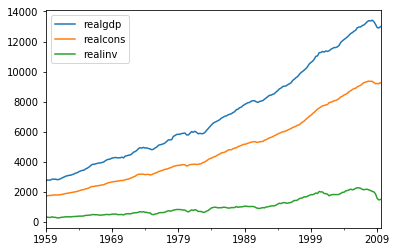

In [5]:
# オリジナル
mdata.plot()

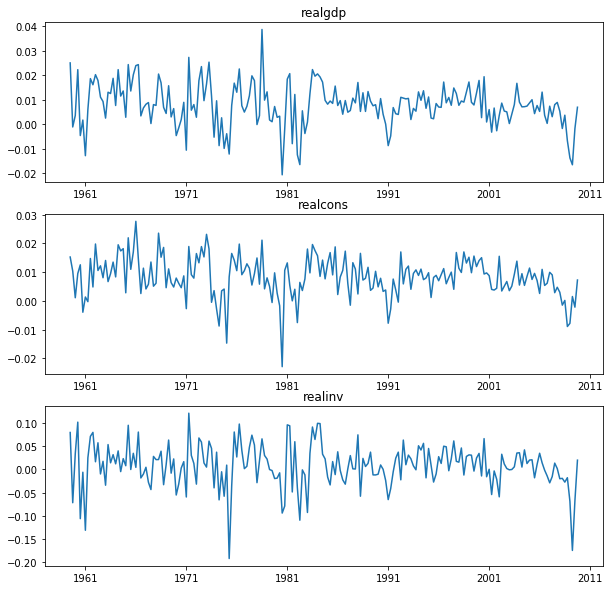

In [6]:
# 対数差分のグラフ
result3.plot()

# インパルス応答
- ある変数の変動が、何期後に別の変数に影響を与えるか？
- 下の図を見ると、
    - realcons -> realgdp に壱期後に強い影響がある
    - realinv  -> realgdp にはそれほど強い影響が見られない
- 予想：
    - realcons -> realgdp には Granger 因果がありそう。
    - realinv  -> realgdp には Granger 因果がなさそう。

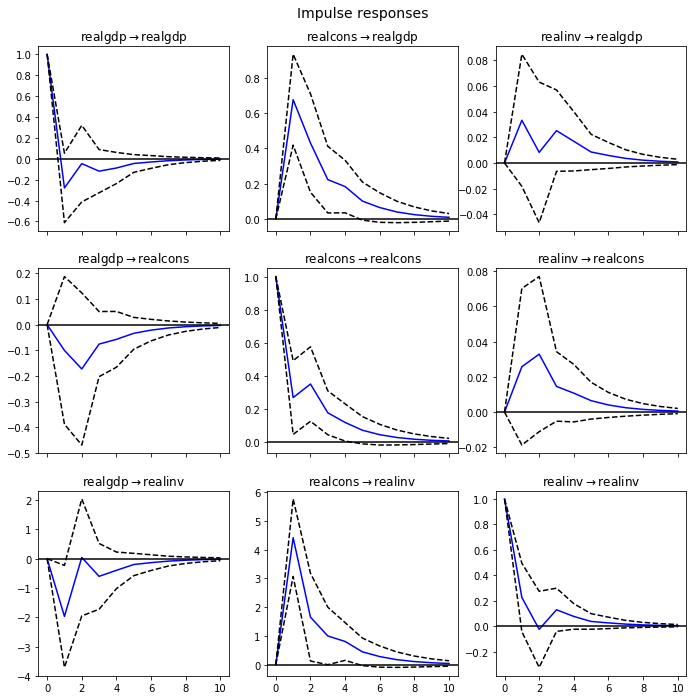

In [7]:
irf = result3.irf(10)
irf.plot(orth=False)

# ここから、グレンジャー因果の判定

## モデルの誤差（残差平方和）を計算する関数
$$ SSR = \sum_{i=1}^{T} (z_i - y_i)^2, $$
- $ z_i $ : 観測値,
- $ y_i $ : モデルの推定値,
- $ T $   : 観測データの個数

In [8]:
def  _compute_zansa_heihou_wa_s(param, y, z, lags):
    y_sample  = y[lags:]
    resid     = y_sample - numpy.dot(z, param.params)
    return  numpy.dot(resid.T, resid)
# End Def (_compute_zansa_heihou_wa_s)

def  compute_zansa_heihou_wa(param):
    y = param.y
    z = param.ys_lagged
    return  _compute_zansa_heihou_wa_s(param, y, z, param.k_ar)
# End Def (compute_zansa_heihou_wa)

In [9]:
compute_zansa_heihou_wa(result2)

array([[ 0.01296159,  0.0548419 ],
       [ 0.0548419 ,  0.37320461]])

In [10]:
compute_zansa_heihou_wa(result3)

array([[ 0.01102293,  0.00575902,  0.04335503],
       [ 0.00575902,  0.00826629,  0.006599  ],
       [ 0.04335503,  0.006599  ,  0.30256801]])

## グレンジャー因果テスト
$$ F = \frac{(SSR_0 - SSR_1) / r}{SSR_1 / d}, \\
d = T - (np + 1), $$

- $SSR_1$ : VAR モデルの残差平方和（沢山の変数で作ったモデル）
- $SSR_0$ : VAR モデルのパラメータのいくつかを零だと仮定したモデルの残差平方和
    - （上のモデルから、何個か変数を削除したモデル）
- $T$ : 観測データの個数
- $r$ : 削除したパラメータの数。

### 帰無仮説
- 削除した変数が、目的変数に対して、Granger 因果を持たない
- 二つのモデルの誤差に有意な差がない。
- 上記の値 F について
    - $r F$ が自由度 r の $\chi^2$ 分布に従う（参考資料の p30, 31 の定義）
    - $F$ が自由度 (r, k d) の F 分布に従う（python パッケージのデフォルト）
- F 分布（または $\chi^2$ 分布）の、95 % 境界点と比較して、上記の F 値の方が大きければ、帰無仮説を棄却し、Granger 因果有りと判定する。
    - 95 % = 事前に決めた適当な有意水準

In [11]:
def  compute_F_statistic(model1, model0, index=0, kind='f'):
    ssr0 = compute_zansa_heihou_wa(model0)[index][index]
    ssr1 = compute_zansa_heihou_wa(model1)[index][index]
    df1  = model1.k_ar
    df2  = model1.nobs - (model1.neqs * model1.k_ar) - model1.k_trend
    print (ssr0, ssr1, df1, df2)
    return  (ssr0 - ssr1) * df2 / (ssr1 * df1), df1, df2

## F 統計量の計算

In [12]:
compute_F_statistic(result3, result2)

0.0129615927663 0.0110229340924 2 193


(16.971938729114594, 2, 193)

## この値と、F 分布の 95% 境界点を比較
- そうすると、16.971 > 3.011 なので、この場合は因果有り。

In [13]:
df = (2, 193 * 3)  ##  * 3 は変数の数（realgdp, realcons, realinv)
dist = scipy.stats.f(*df)
dist.ppf(1 - 0.05)

3.0112857238108681

## 又は、p 値を計算して、5% 未満かどうかを見ても良い。
- p 値 : F 分布が、上記の F 値 (16.9719...) 以上になる確率。
- この場合 p値 < 0.05 なので、因果有り

In [14]:
dist.sf(16.971938729114594)

6.8730304034910541e-08

## なお、F 分布ではなく、$\chi^2$ 分布を使う場合は以下の通り

In [15]:
dist = scipy.stats.chi2(2)
print('stat = ', 16.971938729114594 * 2, ', crit = ', dist.ppf(1 - 0.05))
print(dist.sf(16.971938729114594 * 2))

stat =  33.94387745822919 , crit =  5.99146454711
4.2577549522e-08


# ちなみに…
## こんな面倒な計算しなくても、
## パッケージにちゃんと判定用の関数が付いている

In [16]:
# F 分布
result3.test_causality('realgdp', ['realcons'], kind='f')

Granger causality f-test
   Test statistic   Critical Value          p-value        df
-------------------------------------------------------------
        16.971939         3.011286            0.000  (2, 579)
H_0: ['realcons'] do not Granger-cause realgdp
Conclusion: reject H_0 at 5.00% significance level


{'conclusion': 'reject',
 'crit_value': 3.0112857238108681,
 'df': (2, 579),
 'pvalue': 6.8730304034912989e-08,
 'signif': 0.05,
 'statistic': 16.971938729114509}

In [17]:
result3.test_causality('realgdp', ['realcons'], kind='wald')

Granger causality wald-test
   Test statistic   Critical Value          p-value  df
-------------------------------------------------------
        33.943877         5.991465            0.000   2
H_0: ['realcons'] do not Granger-cause realgdp
Conclusion: reject H_0 at 5.00% significance level


{'conclusion': 'reject',
 'crit_value': 5.9914645471079799,
 'df': 2,
 'pvalue': 4.2577549521963736e-08,
 'signif': 0.05,
 'statistic': 33.943877458229018}

## realinv -> realgdp の場合は因果無し
- F 値 (0.8112) > 3.0112 を満たさない（or p 値 が 0.44 であり 0.05 未満ではない）
- 帰無仮説（因果無し）を棄却できない

In [18]:
result3.test_causality('realgdp', ['realinv'], kind='f')

Granger causality f-test
   Test statistic   Critical Value          p-value        df
-------------------------------------------------------------
         0.811221         3.011286            0.445  (2, 579)
H_0: ['realinv'] do not Granger-cause realgdp
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 3.0112857238108681,
 'df': (2, 579),
 'pvalue': 0.44481964207438718,
 'signif': 0.05,
 'statistic': 0.81122083790581656}

In [19]:
result3.test_causality('realgdp', ['realinv'], kind='wald')

Granger causality wald-test
   Test statistic   Critical Value          p-value  df
-------------------------------------------------------
         1.622442         5.991465            0.444   2
H_0: ['realinv'] do not Granger-cause realgdp
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 5.9914645471079799,
 'df': 2,
 'pvalue': 0.44431529801640213,
 'signif': 0.05,
 'statistic': 1.6224416758116331}